In [1]:
!pip install meteocalc

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')
#!cp /content/drive/MyDrive/ashrae.zip ashrae.zip
#!unzip -q ashrae.zip

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.figure_factory as ff

from IPython.core.pylabtools import figsize
from plotly.offline import init_notebook_mode,iplot,plot
%matplotlib inline
init_notebook_mode(connected=True)
plt.style.use("ggplot")
from sklearn.utils import shuffle

from sklearn.preprocessing import  LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

from keras.models import load_model
from keras.models import Model 
from keras.layers import Input
import keras.backend as K

# importer les fichiers .py sur le notebook
%run utils.py
%run feature_enginering.py

In [4]:
building = pd.read_csv('/content/building_metadata.csv')
weather = pd.read_csv('/content/weather_train.csv')
train = pd.read_csv('/content/train.csv')

# convertir du kwh vers kbtu

train.loc[(train.meter == 0),'meter_reading'] = train['meter_reading'] * 0.2931

In [5]:
building = reduce_mem_usage(building)
weather  = reduce_mem_usage(weather)
train = reduce_mem_usage(train)

In [6]:
building = prepare_building_data(building)
weather = prepare_weather_data(weather)
train  = time_features(train)

In [7]:
def join_data(data , weather_data , building_data):

    data = data.merge(building_data, on = 'building_id' , how='left')
    data = data.merge(weather_data , on = ['site_id','timestamp'], how= 'left')
    data = shuffle(data, random_state=0)

    return data

In [8]:
train = join_data(train , weather , building)

train['log_meter_reading'] = np.log(train['meter_reading'] + 1)
train['month_group'] = train['month_group'] - 1

train = train.drop(['meter_reading'] , axis= 1)

train  = reduce_mem_usage(train)
del weather, building
gc.collect()

26

In [9]:
cols_to_drop = ['year_built' , 'floor_count' , 'timestamp']

cols_to_scale = ['square_feet' , 'air_temperature' , 'dew_temperature' ,
                 'wind_speed', 'cloud_coverage', 'sea_level_pressure', 'wind_direction',
                 'relative_humidity', 'feels_like']

cols_to_encode = ['primary_use' , 'city' , 'country']

cols_to_fill_mean = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
                       'sea_level_pressure','wind_direction' , 'wind_speed', 'relative_humidity' ,
                       'feels_like']

cols_to_fill_categ = ['city' , 'country' , 'is_holiday']


Filler = Data_Filler(cols_to_fill_mean,
                     cols_to_fill_categ)

Filler.fit(train)
train = Filler.transform(train)

ScalerEncoder = Data_Scaler_Encoder(cols_to_scale ,
                                    cols_to_drop , 
                                    cols_to_encode)
ScalerEncoder.fit(train)
train = ScalerEncoder.transform(train)

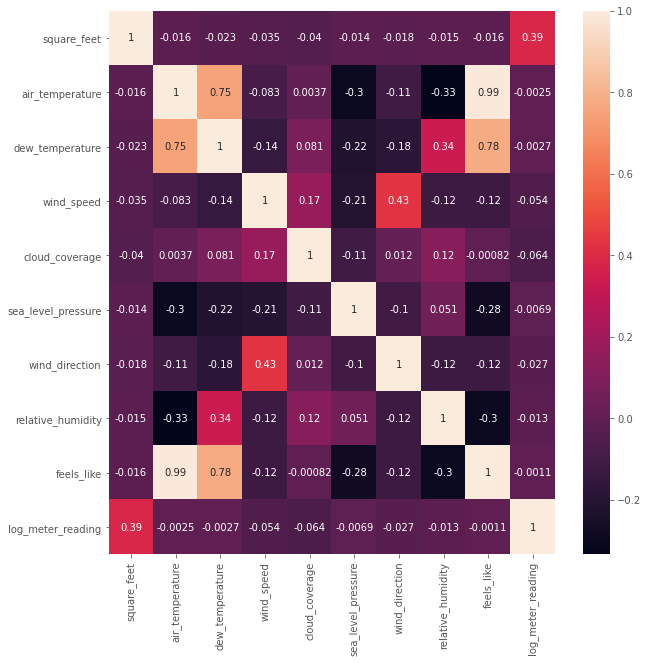

In [10]:
plt.figure(figsize = (10 , 10))
sns.heatmap(train[cols_to_scale + ['log_meter_reading']].corr(), annot=True)
plt.show()

* air_temperature et dew_temperature sont correlees, on enleve une. (air_temperature)

* wind_direction et wind_speed sont correlees, on enleve une. (wind_direction)


In [11]:
def rmse(y_true, y_pred):
    """ root_mean_squared_error """
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [12]:
model = load_model('/content/drive/MyDrive/model_ann_regression.h5' ,
                    custom_objects = {'rmse' : rmse})

In [13]:
model.get_layer('second_to_last_layer').output

<KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'second_to_last_layer')>

In [14]:
transfered_model = Model(model.input , model.get_layer('second_to_last_layer').output )

In [15]:
del model
gc.collect()

9709

In [16]:
train.head()

,building_id,meter,hour,dayofweek,month_group,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,relative_humidity,feels_like,city,country,is_holiday,log_meter_reading
11990877,774,1,8,6,2,6,4,-0.121928,0.622309,-0.493968,1.335863,0.000000,0.971994,-1.508241,-1.586555,1.220804,0.625725,12,3,0.0,3.614396
15256244,206,0,14,1,2,2,9,2.032176,-0.004326,-0.902715,-0.443634,0.000000,0.950487,-0.693963,-0.905198,-0.907559,0.046760,11,3,0.0,4.209454
18401495,1269,0,10,1,2,14,3,-0.438739,-0.733841,-0.902715,-0.273682,0.000000,1.015009,-0.603487,-0.405537,0.755967,-0.627258,7,3,0.0,2.241073
15573710,951,0,4,0,2,9,6,-0.032943,0.098554,-0.902715,-0.213699,0.000000,1.066786,-1.508241,-1.586555,-0.727844,0.141815,0,3,1.0,3.529892
6515439,656,0,21,6,1,5,7,-0.870854,-0.481317,-0.902715,0.226177,-0.041667,0.990017,1.206021,-0.405537,1.372431,-0.393944,10,2,0.0,2.359378


In [17]:
categorical_vars = ['building_id' , 'meter', 'hour', 'dayofweek' ,
                    'month_group', 'site_id' , 'primary_use', 
                    'city', 'country', 'is_holiday']
                    
numerical_vars = ['square_feet', 'cloud_coverage', 'dew_temperature',
                  'precip_depth_1_hr', 'sea_level_pressure', 'wind_speed', 
                  'relative_humidity' , 'feels_like']

target_var = 'log_meter_reading'

co_vars = categorical_vars + numerical_vars

In [ ]:
y = train[target_var].values
y = y.reshape(len(y))

train = train.drop( [target_var] , axis = 1)

In [ ]:
step_size = 500000
nrows = train.shape[0]
num_steps = nrows//step_size
print('nombre d\'iterations' , num_steps)
new_data = []

for j in range(num_steps+1):
    start_idx = j*step_size
    end_idx = (j+1)*step_size
    if j == num_steps : 
        start_idx = j*step_size
        end_idx = nrows
      
    train_tmp = train.iloc[start_idx:end_idx]

    train_tmp = train_tmp[co_vars].values
    train_tmp = [ train_tmp[:,i].flatten() for i in range(len(train_tmp[0,:])) ]
    
    new_vectors = transfered_model.predict(train_tmp)
    new_data.append(new_vectors)
    if j%10==0:
        print('iteration' , j)

nombre d'iterations 40
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40


In [ ]:
new_data = np.concatenate(new_data , axis=0)
new_data = pd.DataFrame(new_data, columns = ['V1','V2','V3'])
new_data['log_meter_reading'] = y

In [ ]:
new_data.head()

,V1,V2,V3,log_meter_reading
0,0.594672,72.893372,-0.348518,3.614396
1,0.966942,76.739189,0.069707,4.209454
2,0.011428,44.236275,-0.205336,2.241073
3,0.679970,56.646912,-0.182595,3.529892
4,0.271904,11.262715,0.063951,2.359378


In [ ]:
new_data.to_csv('new_data.csv' , index=False)

In [ ]:
del new_data
gc.collect()

In [ ]:
del train, train_tmp
gc.collect()

4577

In [19]:
!cp /content/drive/MyDrive/new_data.csv /content/new_data.csv

In [22]:
new_data = pd.read_csv('/content/new_data.csv')
new_data = reduce_mem_usage(new_data)

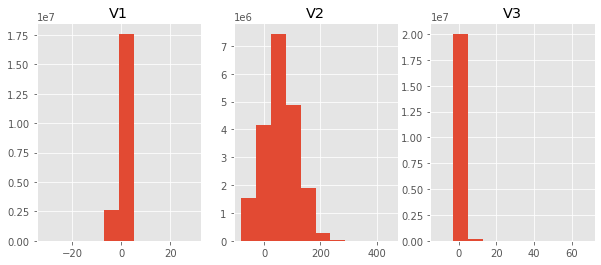

In [23]:
new_columns = ['V1' , 'V2' , 'V3']
fig, axes = plt.subplots(1, 3 , figsize = (10,4))
for i in range(len(new_columns)):
    axes[i].hist(new_data[new_columns[i]], bins=10)
    axes[i].set_title(new_columns[i])
plt.show()

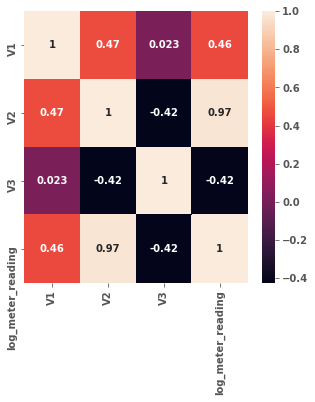

In [24]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

plt.figure(figsize = (5 , 5))
sns.heatmap(new_data.corr(), annot=True)
plt.show()

* il y a une correlation entre V1 et V2 , on supprime une variable, et garder une. on garde V2 parc qu'elle a une correlation plus grande avec la variable à predire.

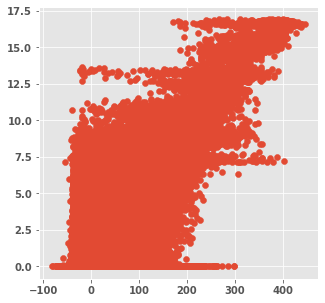

In [ ]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

plt.figure(figsize = (5 , 5))
plt.scatter(new_data.V2.values, new_data.log_meter_reading.values)
plt.show()

In [18]:
new_data = pd.read_csv('/content/new_data.csv')
new_data = reduce_mem_usage(new_data)
new_data = new_data.drop(['V1'] , axis = 1)

y = new_data.log_meter_reading.values
X = new_data.drop(['log_meter_reading'] , axis = 1)

del new_data
gc.collect()

0

In [19]:

GBR =  GradientBoostingRegressor(n_estimators = 100 ,verbose = 1)

GBR.fit(X , y)

      Iter       Train Loss   Remaining Time 
         1           3.8643           59.31m
         2           3.1957           60.13m
         3           2.6487           59.04m
         4           2.2052           58.46m
         5           1.8415           57.54m
         6           1.5476           56.52m
         7           1.3060           56.12m
         8           1.1100           54.98m
         9           0.9508           53.97m
        10           0.8192           53.43m
        20           0.3138           46.91m
        30           0.2449           40.68m
        40           0.2349           34.60m
        50           0.2333           28.77m
        60           0.2331           22.92m
        70           0.2330           17.18m
        80           0.2329           11.45m
        90           0.2329            5.71m
       100           0.2329            0.00s


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=1, warm_start=False)

In [45]:
del X,y
gc.collect()

330

In [20]:
test = pd.read_csv('/content/test.csv')
weather_test = pd.read_csv('/content/weather_test.csv')
building = pd.read_csv('/content/building_metadata.csv')


weather_test = prepare_weather_data(weather_test)
building = prepare_building_data(building)
test = time_features(test)

weather_test  = reduce_mem_usage(weather_test)
building = reduce_mem_usage(building)
test = reduce_mem_usage(test)

In [21]:
co_vars = categorical_vars + numerical_vars

step_size = 500000
nrows = test.shape[0]
num_steps = nrows//step_size
print('nombre d\'iterations' , num_steps)

row_id = np.array([])
meter_values = np.array([])
y_pred = np.array([])

for j in range(num_steps+1):
    start_idx = j*step_size
    end_idx = (j+1)*step_size
    if j == num_steps : 
        start_idx = j*step_size
        end_idx = nrows
      
    test_tmp = test.iloc[start_idx:end_idx]
    
    test_tmp = join_data(test_tmp , weather_test , building)
    test_tmp = Filler.transform(test_tmp)
    test_tmp = ScalerEncoder.transform(test_tmp)
    test_tmp['month_group'] = test_tmp['month_group'] - 1
    
    row_id_tmp = test_tmp['row_id'].values
    row_id = np.concatenate((row_id,row_id_tmp))

    test_tmp = test_tmp.drop(['row_id'] , axis= 1)

    meter_values_tmp = test_tmp['meter'].values
    meter_values = np.concatenate((meter_values,meter_values_tmp))

    test_tmp = test_tmp[co_vars].values
    test_tmp = [ test_tmp[:,i].flatten() for i in range(len(test_tmp[0,:])) ]
    
    new_test_data = transfered_model.predict(test_tmp)
    new_test_data = new_test_data[:,1:3] # on recupere V2 , V3
    #new_test_data = poly.transform(new_test_data)
    
    predictions = GBR.predict(new_test_data)
    y_pred = np.concatenate((y_pred,predictions))
    
    if j%10==0:
        print('iteration' , j)

nombre d'iterations 83
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80


In [46]:
del building, weather_test, test
gc.collect()

129

In [22]:
pred_final = {'row_id': row_id, 'meter' : meter_values , 'meter_reading': y_pred}
pred_final = pd.DataFrame(data = pred_final)
pred_final.row_id = pred_final.row_id.astype('int32')
pred_final['meter_reading'] = np.exp(pred_final['meter_reading']) - 1

KWH_TO_KBTU = 0.2931
pred_final.loc[(pred_final.meter == 0),'meter_reading'] = pred_final['meter_reading'] / KWH_TO_KBTU 

pred_final = pred_final.sort_values(by=['row_id'])
pred_final = pred_final.drop(['meter'] , axis = 1)

pred_final.loc[pred_final.meter_reading < 0 , 'meter_reading'] = 0

pred_final.row_id.unique().shape

(41697600,)

In [23]:
pred_final

,row_id,meter_reading
281960,0,0.041510
413175,1,0.041510
162930,2,0.034373
374150,3,0.041510
431176,4,0.041510
...,...,...
41542027,41697595,5.283118
41640202,41697596,3.462786
41618431,41697597,7.252460
41604830,41697598,170.229841


In [24]:
compression_opts = dict(method='zip',archive_name='transfer_learning_out_o.csv')  
pred_final.to_csv('transfer_learning_out_o.zip', index=False,compression=compression_opts)

!cp transfer_learning_out_o.zip /content/drive/MyDrive/transfer_learning_out_o.zip